In [1]:
#Importo librerías necesarias
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#Cuestiones previas:
###1. La forma de guardar la información de las masas es la siguiente:
+ Cada una tiene dos componentes: un vector $r$ (que contiene posición en $\hat{\textbf{i}}$ y $\hat{\textbf{j}}$) y un vector $v$ (que contiene velocidad en $\hat{\textbf{i}}$ y $\hat{\textbf{j}}$).
+ El array Y contiene la información de **todas** las masas en cuestión. El orden de la información contenida en este array es: [$r_1,v_1,r_2,v_2, \dots ,r_n,v_n$]. Definidos $r$ y $v$ como se explicó en el punto anterior.

###2. Se utilizó la siguiente fórmula para de interacción gravitacional (Asumiendo $G = 1$):

$$m_i \dfrac{d^2x}{dt^2} = - \sum_{i \neq j} \dfrac{m_i m_j (x_i - x_j)}{r^3_{ij}}\\$$
$$i = 1, \dots , N$$

###3. Se utilizó el método de Runge-Kutta de orden 4 para resolver las ecuaciones diferenciales de movimiento. Recordando que este se basa en que:

$$\dfrac{d}{dt} Y(t) = f(Y)$$

###4. Todo lo aquí hecho se basa en la información de esta [página.](http://www14.in.tum.de/konferenzen/Jass05/courses/2/Lapshin/Lapshin_paper.pdf)

In [2]:
#Se define la función f(Y) y el método de Runge-Kutta basados en la explicación anterior y 
#en lo tomado del cuaderno de la clase de ODE
#https://github.com/ComputoCienciasUniandes/MetodosComputacionales/blob/master/slides/2015-V/10-ODE.ipynb
def f(Y):
    info = []
    for i in range(0,len(Y),2):
        v = 0
        for j in range(0,len(Y),2):
            if (j!=i):
                v += ((Y[i] - Y[j]) / np.sqrt(Y[i]**2 + Y[j]**2)**3)
        info.extend((Y[i+1],-v))
    return(np.array(info))

def one_Kutta4_step():
    #global t
    global Deltat
    global Y
    K1 = f(Y)
    K2 = f(Y + Deltat*(1/2.*K1))
    K3 = f(Y + Deltat*(1./2.*K2))
    K4 = f(Y + Deltat*K3)
    Y += Deltat * (1/6.*K1 + 1/3. * K2 + 1/3.*K3 + 1/6.*K4)

def graficador():
    plt.figure()
    plt.title("Kutta Orden 4")
    plt.axis('equal')
    for i in range(0,len(Y),2):
        plt.plot(history[:,i][:,0],history[:,i][:,1],"o",ms=1)
    plt.show()

##Punto 1) 3-Coreografía

In [3]:
#Defino las ecuaciones iniciales
a = 0.24250109
b = -0.0607718825
c = 0.93240737
d = 0.86473146

#Se ordena la información de cada masa y la del total en Y basados en la explicación inicial.
r1 = np.array([a,b])
r2 = np.array([-a,-b])
r3 = np.array([0,0])

v1 = np.array([c,d])
v2 = np.array([c,d])
v3 = np.array([-2*c,-2*d])

Y = np.array([r1,v1,r2,v2,r3,v3])

#### Pruebas - ignorar -
#y1 = np.array([a,b,c,d])
#
#y2 = np.array([-a,-b,c,d])
#
#y3 = np.array([0,0,-2*c,-2*d])
#
#Y = np.array([y1,y2,y3])

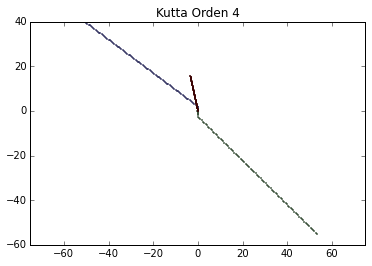

In [4]:
chosenstep=one_Kutta4_step
numIter=100
tmax=2*np.pi
Deltat=tmax/numIter
history=np.array([[Y[0],Y[1],Y[2],Y[3],Y[4],Y[5]]])
for __ in range(numIter):
    chosenstep()
    history=np.append(history,[[Y[0],Y[1],Y[2],Y[3],Y[4],Y[5]]],axis=0)
graficador()